### imports

In [1]:
from theano.sandbox import cuda
cuda.use('gpu1')
from sklearn.preprocessing import LabelEncoder
import cv2
import glob
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from collections import Counter


WARNING (theano.sandbox.cuda): Ignoring call to use(1), GPU number 0 is already in use.


In [2]:
%matplotlib inline
import utils;
reload(utils)
from utils import *
from __future__ import division, print_function

In [34]:
#path = "data/fish/sample/"
path = "/datadrive/kaggle_fisherman/"
model_path='/datadrive/kaggle_fisherman/'
batch_size=64

### functions

In [4]:
def get_im_cv2(path, img_rows, img_cols, color_type=1):
    # Load as grayscale
    if color_type == 1:
        img = cv2.imread(path, 0)
    elif color_type == 3:
        img = cv2.imread(path)
    # Reduce size
    resized = cv2.resize(img, (img_cols, img_rows))
    return resized

In [5]:
def load_train(img_rows, img_cols, color_type=1):
    X_train = []
    y_train = []
    driver_id = []

    #driver_data = get_driver_data()

    print('Read train images')
    for j in unique_fish_cats:
        print('Load folder {}'.format(j))
        path = os.path.join( j, '*.jpg')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = get_im_cv2(fl, img_rows, img_cols, color_type)

            X_train.append(img)
            y_train.append(j)
            #driver_id.append(driver_data[flbase])

    unique_drivers = sorted(list(set(driver_id)))
    print('Unique drivers: {}'.format(len(unique_drivers)))
    print(unique_drivers)
    return X_train, y_train, driver_id, unique_drivers


In [6]:
def load_train_2(img_rows, img_cols, color_type=1): # - with no outer loop
    X_train = []
    y_train = []
    driver_id = []

    #driver_data = get_driver_data()

    print('Read train images')
    #for j in unique_fish_cats:
    #print('Load folder {}'.format(j))
    path = os.path.join('*/*.jpg')
    files = glob.glob(path)
    for fl in files:
        flbase = os.path.basename(fl)
        img = get_im_cv2(fl, img_rows, img_cols, color_type)

        X_train.append(img)
        j=fl.split('/')[0]
        y_train.append(j)
        #driver_id.append(driver_data[flbase])

    unique_drivers = sorted(list(set(driver_id)))
    print('Unique drivers: {}'.format(len(unique_drivers)))
    print(unique_drivers)
    return X_train, y_train

In [7]:
def logo(group_to_leave=1):
    i=1
    stop=group_to_leave
    for train_index, test_index in logo.split(train_array, y, size_id_list_2):
        Xtrain, Xval, ytrain,yval  = train_array[train_index], train_array[test_index], oh_classes_array[train_index], oh_classes_array[test_index]
        if i==stop:
            break
        i+=1
    return Xtrain, Xval, ytrain,yval#leaves one group of ship out


In [8]:
def load_test(img_rows, img_cols, color_type=1):
    print('Read test images')
    path = os.path.join( 'unknown/*.jpg')
    files = glob.glob(path)
    X_test = []
    X_test_id = []
    total = 0
    thr = math.floor(len(files)/10)
    for fl in files:
        flbase = os.path.basename(fl)
        img = get_im_cv2(fl, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(flbase)
        total += 1
        if total%thr == 0:
            print('Read {} images from {}'.format(total, len(files)))

    return X_test, X_test_id

In [9]:
def one_hot_label_encode(y):

    le=LabelEncoder()

    oh=OneHotEncoder()

    int_classes=le.fit_transform(y)
    oh_classes=oh.fit_transform(int_classes.reshape(int_classes.shape[0],1)) #this reshape is bcz the one hot encoder likes this format
    return oh_classes

## init

### general init

In [10]:
%cd /datadrive/kaggle_fisherman/train

/datadrive/kaggle_fisherman/train


In [11]:
#load all files, be in train folder
from glob import glob
e = glob('*/*.jpg')

In [12]:
#fish categories list
fish_cats=[i.split('/')[0] for i in e]
unique_fish_cats=np.unique(fish_cats)

In [13]:
#get list of image sizes
sizes = [PIL.Image.open(path+'train/'+f).size for f in e]
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}

In [14]:
%cd /datadrive/kaggle_fisherman/test

/datadrive/kaggle_fisherman/test


In [15]:
#load all files, be in test folder
import glob
t=glob.glob('*/*.jpg')

In [16]:
test_sizes = [PIL.Image.open(path+'test/'+f).size for f in t]

In [17]:
size_id_list=[size2id[size] for size in sizes]


In [18]:
%cd /datadrive/kaggle_fisherman/train
img_rows, img_cols, color_type=224,224,3
train=load_train_2(img_rows, img_cols, color_type)
train_array=np.array(train[0])

/datadrive/kaggle_fisherman/train
Read train images
Unique drivers: 0
[]


In [19]:
test=load_test(img_rows, img_cols, color_type)
test_array=np.array(test[0])

Read test images


In [20]:
train_array=np.array(train[0])
train_array.shape

(3777, 224, 224, 3)

In [21]:
#make train numpy, reshape

new_train_array=np.zeros([3777,3,224,224])
new_train_array[:,0,:,:]=train_array[:,:,:,0]
new_train_array[:,1,:,:]=train_array[:,:,:,1]
new_train_array[:,2,:,:]=train_array[:,:,:,2]
train_array=new_train_array

In [22]:
y=fish_cats
oh_classes=one_hot_label_encode(y)
oh_classes_array=oh_classes.toarray() #there is a keras function that does this -"to_categorical"

In [23]:
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()
logo.get_n_splits(train, y, size_id_list)

10

### stratifed validation set

In [107]:
#make_stratified_by test part 1
sum=0
train_ratios=[Counter(sizes)[size] for  size in Counter(sizes)]
test_ratios=[Counter(test_sizes)[tsize] for  tsize in Counter(test_sizes)]
cum_train_ratios=[]
for i in train_ratios:
    cum_train_ratios.append(sum)
    sum+=i

In [153]:

test_index=np.array([])
for group_size,test_group_size,cumsum in zip(train_ratios,test_ratios,cum_train_ratios):
    test_index=np.append(test_index,np.random.choice(group_size,int(group_size*(test_group_size/1000)))+cumsum)

test_index=test_index.astype(int)
train_index=[i not in test_index  for i in np.arange(3777)]
test_index=[i in test_index  for i in np.arange(3777)]

In [113]:
#use this for statified
Xtrain, Xval, ytrain,yval  = train_array[train_index], train_array[test_index], oh_classes_array[train_index], oh_classes_array[test_index]

In [156]:
np.sum(test_index)

1133

### just random train/valid

In [25]:
size_id_list_shuffled=np.random.randint(min(size_id_list),max(size_id_list),len(size_id_list))

In [26]:
i=1
stop=1
for train_index, test_index in logo.split(train_array, y, size_id_list_shuffled):
    Xtrain, Xval, ytrain,yval  = train_array[train_index], train_array[test_index], oh_classes_array[train_index], oh_classes_array[test_index]
    if i==stop:
        break
    i+=1

In [27]:
len(Xtrain), len(Xval)

(3372, 405)

### logo validation set

In [24]:
Counter(size_id_list)

Counter({0: 395,
         1: 27,
         2: 35,
         3: 31,
         4: 198,
         5: 2174,
         6: 220,
         7: 598,
         8: 39,
         9: 60})

In [25]:
#make logo
i=1
stop=10
for train_index, test_index in logo.split(train_array, y, size_id_list):
    Xtrain, Xval, ytrain,yval  = train_array[train_index], train_array[test_index], oh_classes_array[train_index], oh_classes_array[test_index]
    if i==stop:
        break
    i+=1
    
#val_indices=val_indices.astype(int)
#train_indices=[i not in val_indices  for i in np.arange(3777)]

In [26]:
Xtrain.shape, Xval.shape, ytrain.shape,yval.shape

((3717, 3, 224, 224), (60, 3, 224, 224), (3717, 8), (60, 8))

### starter model definitions

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()
from vgg16bn import Vgg16BN
model = vgg_ft_bn(8)

In [28]:
model.compile(optimizer=Adam(1e-3),loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
conv_layers,fc_layers = split_at(model, Convolution2D)

In [30]:
conv_model = Sequential(conv_layers)

this needs to be retrained when replitting (or loaded)

In [31]:
conv_feat = conv_model.predict(Xtrain)
conv_val_feat = conv_model.predict(Xval)

In [275]:
conv_feat_all = conv_model.predict(train_array)

In [35]:
split_type='ship_10_removed'
save_array(model_path+'results/conv_val_feat'+split_type+'.dat', conv_val_feat)
save_array(model_path+'results/conv_feat'+split_type+'.dat', conv_feat)

In [218]:
split_type='ship_5_removed'
conv_val_feat=load_array(model_path+'results/conv_val_feat'+split_type+'.dat')
conv_feat=load_array(model_path+'results/conv_feat'+split_type+'.dat')

## basic stuff - do not use

In [32]:
model.fit(Xtrain,ytrain,nb_epoch=3,validation_data=(Xval,yval))

NameError: name 'Xtrain' is not defined

In [30]:
model_path='/datadrive/kaggle_fisherman/'

In [173]:
model.save_weights(model_path+'models/ft1.h5')

In [174]:
save_array(model_path+'results/Xtrain.dat', Xtrain)
save_array(model_path+'results/ytrain.dat', ytrain)
save_array(model_path+'results/Xval.dat', Xval)
save_array(model_path+'results/yval.dat', yval)

## do more serious work

In [50]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/4),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(8, activation='softmax')
    ]

In [116]:
p=0.5

In [36]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

NameError: name 'p' is not defined

In [113]:
bn_model.fit(conv_feat,ytrain,batch_size=64,nb_epoch=3,validation_data=(conv_val_feat,yval))

Train on 3382 samples, validate on 395 samples
Epoch 1/3
3382/3382 [==============================] - 1s - loss: 1.3458 - acc: 0.6168 - val_loss: 5.6452 - val_acc: 0.1544

In [107]:
bn_model.optimizer.lr = 1e-4
bn_model.fit(conv_feat,ytrain,batch_size=64,nb_epoch=7,validation_data=(conv_val_feat,yval))

Train on 3382 samples, validate on 395 samples
Epoch 1/7
3382/3382 [==============================] - 1s - loss: 0.0217 - acc: 0.9959 - val_loss: 2.7657 - val_acc: 0.1722

## multi output

### mouth tail annotation

In [89]:
#natis mt
anno_mt_classes=[anno.lower() for anno in unique_fish_cats]

In [132]:
#natis mt
import ujson as json
mt_json = {}
for c in anno_mt_classes:
    j = json.load(open('{}annos_mtail/{}_labels.json'.format(model_path, c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>1:
            print(l['annotations'])
            print (l['annotations'][0].items(),l['annotations'][1].items())
            mt_json[l['filename'].split('/')[-1]] = l['annotations']

[{u'y': 342.8499725255559, u'x': 825.5028464692997, u'class': u'point'}, {u'y': 449.36646884417524, u'x': 1095.1227277758048, u'class': u'point'}]
[(u'y', 342.8499725255559), (u'x', 825.5028464692997), (u'class', u'point')] [(u'y', 449.36646884417524), (u'x', 1095.1227277758048), (u'class', u'point')]
[{u'y': 606.0901688065899, u'x': 721.6156429713819, u'class': u'point'}, {u'y': 433.6390986765381, u'x': 688.1299982859349, u'class': u'point'}]
[(u'y', 606.0901688065899), (u'x', 721.6156429713819), (u'class', u'point')] [(u'y', 433.6390986765381), (u'x', 688.1299982859349), (u'class', u'point')]
[{u'y': 514.0046459216107, u'x': 492.23897687607024, u'class': u'point'}, {u'y': 681.4328693488455, u'x': 602.7416043380452, u'class': u'point'}]
[(u'y', 514.0046459216107), (u'x', 492.23897687607024), (u'class', u'point')] [(u'y', 681.4328693488455), (u'x', 602.7416043380452), (u'class', u'point')]
[{u'y': 359.55000000000035, u'x': 258.03000000000026, u'class': u'point'}, {u'y': 396.21000000000

In [133]:
#nati mt
for f in raw_filenames:
    if not f in mt_json.keys(): mt_json[f] = [empty_mt]
for f in raw_val_filenames:
    if not f in mt_json.keys(): mt_json[f] = [empty_mt]

### prepare mbounding boxes stuff

In [83]:
anno_classes=[anno.upper() for anno in unique_fish_cats]

In [96]:
anno_mt_classes.remove('nof')
anno_classes.remove('NOF')

In [39]:
import ujson as json
bb_json = {}
for c in anno_classes:
    j = json.load(open('{}annos/{}_labels.json'.format(model_path, c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(l['annotations'], key=lambda x: x['height']*x['width'])[-1]

#### start here after resplit

In [40]:
filenames=np.array(e)[train_index] #train index is the one group out, train indixes is the stratifeid
val_filenames=np.array(e)[test_index]

In [41]:
raw_filenames = [f.split('/')[-1] for f in filenames]
#raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

In [42]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

In [43]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

In [130]:
empty_mt={u'y': 0, u'x': 0, u'class': u'point'}, {u'y': 0, u'x': 0, u'class': u'point'}

In [44]:
for f in raw_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

In [45]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [46]:
train_sizes,raw_val_sizes=np.array(sizes)[train_index],np.array(sizes)[test_index]

In [47]:
#need sizes from multi inputs
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, train_sizes)],).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)

In [48]:
trn_bbox.shape,val_bbox.shape

((3717, 4), (60, 4))

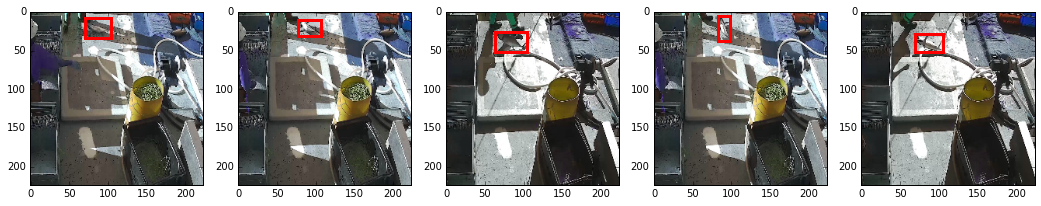

In [136]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def create_rect2(bb, color='blue'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i):
    bb = val_bbox[i]
    plot(Xval[i])
    plt.gca().add_patch(create_rect(bb))
    
def show_bb_trn(i):
    bb = trn_bbox[i]
    plot(Xtrain[i])
    plt.gca().add_patch(create_rect(bb))
    
fig = plt.figure( figsize=(18, 18))

for i in range(5):
    z = fig.add_subplot(1,5,i+1)
    show_bb(i)
plt.show()

### some tests

In [187]:
#testing
i=99
f=filenames[i]
f_1=raw_filenames[i]
box=bb_json[f_1]

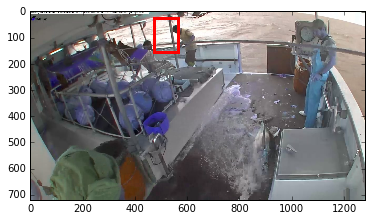

In [188]:
im=cv2.imread(e[i])
plt.imshow(im)
plt.gca().add_patch(plt.Rectangle((box['x'],box['y']), box['width'],box['height'], color='r', fill=False, lw=3))

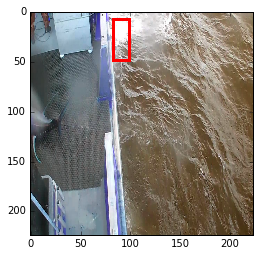

In [189]:
plot(Xtrain[i])
plt.gca().add_patch(create_rect(convert_bb(bb_json[f_1], train_sizes[2])))

### train

In [50]:
p=0.5

In [51]:
inp = Input(conv_layers[-1].output_shape[1:])
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)

In [52]:
model = Model([inp], [x_bb, x_class])
model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],loss_weights=[.001, 1.])

In [57]:
model.fit(conv_feat, [trn_bbox, ytrain], batch_size=batch_size, nb_epoch=3, validation_data=(conv_val_feat, [val_bbox, yval]))

Train on 3717 samples, validate on 60 samples
Epoch 1/3
3717/3717 [==============================] - 1s - loss: 3.1999 - bb_loss: 3126.3764 - class_loss: 0.0735 - bb_acc: 0.5967 - class_acc: 0.9833 - val_loss: 3.4255 - val_bb_loss: 622.0417 - val_class_loss: 2.8035 - val_bb_acc: 0.9333 - val_class_acc: 0.0833

In [ ]:
model.optimizer.lr = 1e-5

In [ ]:
model.fit(conv_feat, [trn_bbox, ytrain], batch_size=batch_size, nb_epoch=10, validation_data=(conv_val_feat, [val_bbox, yval]))

In [189]:
conv_feat.shape

(3382, 512, 14, 14)

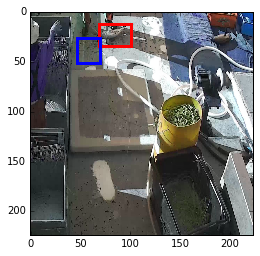

In [60]:
#try predict boxes
val_preds=model.predict(conv_val_feat)
predicted_boxes=val_preds[0]
def show_bb_val(i):
    bb = val_bbox[i]
    bb_pred=(predicted_boxes[i])
    plot(Xval[i])
    plt.gca().add_patch(create_rect(bb))
    plt.gca().add_patch(create_rect2(bb_pred))


show_bb_val(8)

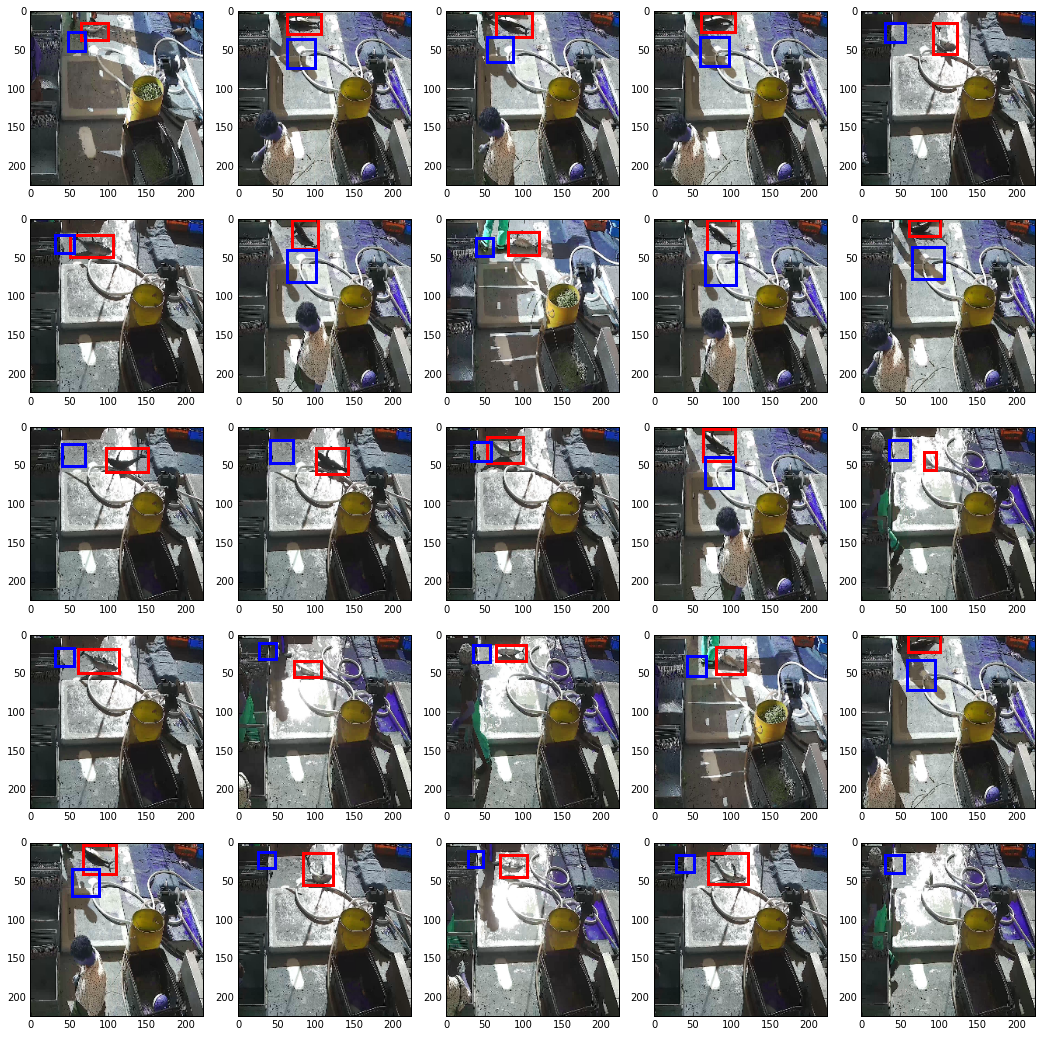

In [61]:
fig = plt.figure( figsize=(18, 18))

for i in range(25,50):
    z = fig.add_subplot(5,5,i+-24)
    show_bb_val(i)
plt.show()

In [ ]:
np.array(size_id_list)[test_index]

### check bb results

## larger size images

### prepare

In [120]:
import glob
img_rows, img_cols, color_type=360,640,3
train=load_train_2(img_rows, img_cols, color_type)

Read train images
Unique drivers: 0
[]


In [123]:
train_array=np.array(train[0])
new_train_array=np.zeros([3777,3,360,640])
new_train_array[:,0,:,:]=train_array[:,:,:,0]
new_train_array[:,1,:,:]=train_array[:,:,:,1]
new_train_array[:,2,:,:]=train_array[:,:,:,2]
train_array=new_train_array

In [126]:
train_array.shape

(3777, 3, 360, 640)

In [32]:
test=load_test(img_rows, img_cols, color_type)
test_array=np.array(test[0])

Read test images
Read 100 images from 1000
Read 200 images from 1000
Read 300 images from 1000
Read 400 images from 1000
Read 500 images from 1000
Read 600 images from 1000
Read 700 images from 1000
Read 800 images from 1000
Read 900 images from 1000
Read 1000 images from 1000


### train

In [128]:
vgg640 = Vgg16BN((360, 640)).model
vgg640.pop()
vgg640.input_shape, vgg640.output_shape
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

/home/ubuntu/.local/lib/python2.7/site-packages/keras/layers/core.py:621: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 360, 640)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [129]:
conv_val_feat = vgg640.predict(Xval, batch_size=32, verbose=1)
conv_trn_feat = vgg640.predict(Xtrain, batch_size=32, verbose=1)

3382/3382 [==============================] - 424s     

In [130]:
save_array(model_path+'results/conv_val_640.dat', conv_val_feat)
save_array(model_path+'results/conv_trn_640.dat', conv_trn_feat)

In [247]:
test_array=np.array(test[0])
conv_test_feat = vgg640.predict(test_array, batch_size=32, verbose=1) #need to by 640X360

In [132]:
#fcn
conv_layers,_ = split_at(vgg640, Convolution2D)

In [138]:
nf=128; p=0.5

In [134]:
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D((1,2)),
        Convolution2D(8,3,3, border_mode='same'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [135]:
lrg_model = Sequential(get_lrg_layers())

In [139]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [140]:
lrg_model.fit(conv_trn_feat, ytrain, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, yval))

Train on 3382 samples, validate on 395 samples
Epoch 1/2
3382/3382 [==============================] - 13s - loss: 0.1018 - acc: 0.9722 - val_loss: 4.0353 - val_acc: 0.3519

In [151]:
lrg_model.optimizer.lr = 1e-5

In [152]:
lrg_model.fit(conv_trn_feat, ytrain, batch_size=batch_size, nb_epoch=7, 
             validation_data=(conv_val_feat, yval))

Train on 3382 samples, validate on 395 samples
Epoch 1/7
3382/3382 [==============================] - 13s - loss: 0.0112 - acc: 0.9967 - val_loss: 8.1016 - val_acc: 0.1949

In [153]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-4].output)

In [154]:
def get_cm(imp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640), interp='nearest')

In [155]:
inp = np.expand_dims(conv_val_feat[0], 0)
np.round(lrg_model.predict(inp)[0],2)

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

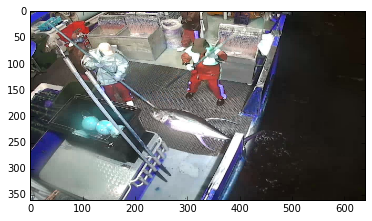

In [156]:
i=3
cm = get_cm(inp, i)
plt.imshow(to_plot(Xval[i]))

In [157]:
cm.shape

(360, 640)

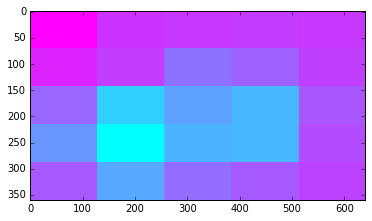

In [158]:
plt.imshow(cm, cmap="cool")

In [159]:
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(8,3,3, border_mode='same'),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [160]:
def get_cm2(imp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640))

In [161]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-3].output)

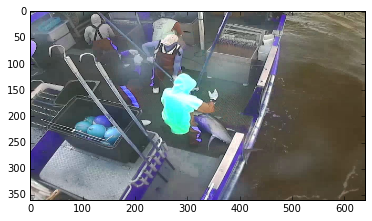

In [162]:
plt.imshow(to_plot(Xval[5]))

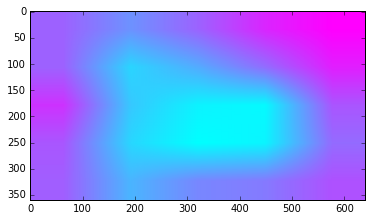

In [163]:
cm = get_cm2(inp, 0)
cm = get_cm2(inp, 5)
plt.imshow(cm, cmap="cool")

## inception mini net

In [174]:
def conv2d_bn(x,nb_filter,nb_row,nb_col,subsample=(1,1)):
    x=Convolution2D(nb_filter,nb_row,nb_col,subsample=subsample,activation='relu',border_mode='same')(x)
    return BatchNormalization(axis=1)(x)

In [165]:
def incep_block(x):
    branch1x1 = conv2d_bn(x, 32, 1, 1, subsample=(2, 2))
    branch5x5 = conv2d_bn(x, 24, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 32, 5, 5, subsample=(2, 2))

    branch3x3dbl = conv2d_bn(x, 32, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3, subsample=(2, 2))

    branch_pool = AveragePooling2D(
        (3, 3), strides=(2, 2), border_mode='same')(x)
    branch_pool = conv2d_bn(branch_pool, 16, 1, 1)
    return merge([branch1x1, branch5x5, branch3x3dbl, branch_pool],
              mode='concat', concat_axis=1)

In [175]:
inp = Input(vgg640.layers[-1].output_shape[1:]) 
x = BatchNormalization(axis=1)(inp)
x = incep_block(x)
x = incep_block(x)
x = incep_block(x)
x = Dropout(0.75)(x)
x = Convolution2D(8,3,3, border_mode='same')(x)
x = GlobalAveragePooling2D()(x)
outp = Activation('softmax')(x)

In [176]:
inc_model = Model([inp], outp)

In [177]:
inc_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [180]:
inc_model.fit(conv_trn_feat, ytrain, batch_size=batch_size, nb_epoch=2, validation_data=(conv_val_feat, yval))

Train on 3382 samples, validate on 395 samples
Epoch 1/2
3382/3382 [==============================] - 8s - loss: 1.2622 - acc: 0.5763 - val_loss: 1.9244 - val_acc: 0.0987

In [182]:
lrg_model.optimizer.lr=1e-5
lrg_model.fit(conv_trn_feat, ytrain, batch_size=batch_size, nb_epoch=6, 
             validation_data=(conv_val_feat, yval))

Train on 3382 samples, validate on 395 samples
Epoch 1/6
3382/3382 [==============================] - 8s - loss: 0.1287 - acc: 0.9666 - val_loss: 2.9084 - val_acc: 0.0582

## Data augmentation

I use the keras iamge data generator.

In [51]:
from keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator, array_to_img

imgen = ImageDataGenerator() #this is the data generator for the augmentation... lets start slow

imgen_train = imgen.flow(Xtrain, ytrain, seed=np.random.randint(1, 10000),shuffle=False)

In [45]:
def single_generator(imgen):
    """
    A generator to train our keras neural network. It
    takes the image augmenter generator and the array
    of the pre-extracted features.
    It yields a minibatch and will run indefinitely
    """
    while True:
        for i in range(Xtrain.shape[0]):
            # Get the image batch and labels
            batch_img, batch_y = next(imgen)
            # This is where that change to the source code we
            # made will come in handy. We can now access the indicies
            # of the images that imgen gave us.
            #x = X[imgen.index_array]
            yield batch_img, batch_y

In [52]:
#model = leaf_utils.combined_model()
model.fit_generator(single_generator(imgen_train),
                              samples_per_epoch=800,
                              nb_epoch=2,
                              validation_data=(Xval,yval),
                              nb_val_samples=Xval.shape[0],verbose=1)

Epoch 1/2
800/800 [==============================] - 30s - loss: 13.1140 - acc: 0.1150 - val_loss: 13.6112 - val_acc: 0.1038